<a href="https://colab.research.google.com/github/Meowmixforme/Kaggle_Machine_Learning_Projects/blob/main/Project%204%20Cats%20vs%20Dogs/Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cats vs Dogs

Author: James Fothergill

In [59]:
# Import packages

# Dataset available at https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import zipfile

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

from google.colab import files

sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [60]:
#  Kaggle Authentication and Dataset Download

files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle

# Download and extract
!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification

with zipfile.ZipFile("cats-and-dogs-image-classification.zip", "r") as zip_ref:
    zip_ref.extractall("cats_and_dogs_data")

Saving kaggle.json to kaggle (7).json
Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification
License(s): CC0-1.0
cats-and-dogs-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [61]:
# Build DataFrames

def gather_df(image_root):
    filepaths = []
    labels = []
    for label in ["cats", "dogs"]:
        folder = image_root / label
        if not folder.exists():
            print(f"Warning: {folder} does not exist")
            continue
        for fp in folder.glob("*.jpg"):
            filepaths.append(str(fp))
            labels.append(label[:-1].capitalize())  # 'cats'->'Cat', 'dogs'->'Dog'
    return pd.DataFrame({"Filepath": filepaths, "Label": labels})

train_dir = Path("cats_and_dogs_data/train")
test_dir  = Path("cats_and_dogs_data/test")
train_df = gather_df(train_dir)
test_df  = gather_df(test_dir)

print("Train DataFrame shape:", train_df.shape)
print("Train labels:", train_df["Label"].unique())
print(train_df.head())
print("\nTest DataFrame shape:", test_df.shape)
print("Test labels:", test_df["Label"].unique())
print(test_df.head())

Train DataFrame shape: (557, 2)
Train labels: ['Cat' 'Dog']
                                    Filepath Label
0  cats_and_dogs_data/train/cats/cat_450.jpg   Cat
1  cats_and_dogs_data/train/cats/cat_260.jpg   Cat
2  cats_and_dogs_data/train/cats/cat_591.jpg   Cat
3  cats_and_dogs_data/train/cats/cat_149.jpg   Cat
4  cats_and_dogs_data/train/cats/cat_243.jpg   Cat

Test DataFrame shape: (140, 2)
Test labels: ['Cat' 'Dog']
                                   Filepath Label
0  cats_and_dogs_data/test/cats/cat_520.jpg   Cat
1  cats_and_dogs_data/test/cats/cat_342.jpg   Cat
2  cats_and_dogs_data/test/cats/cat_341.jpg   Cat
3  cats_and_dogs_data/test/cats/cat_417.jpg   Cat
4   cats_and_dogs_data/test/cats/cat_18.jpg   Cat


In [62]:
# Split Data into Train/Validation Sets

train_split, val_split = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df["Label"]
)

print("Train split counts:\n", train_split["Label"].value_counts())
print("Val split counts:\n", val_split["Label"].value_counts())

Train split counts:
 Label
Cat    223
Dog    222
Name: count, dtype: int64
Val split counts:
 Label
Dog    56
Cat    56
Name: count, dtype: int64


In [63]:
# ImageDataGenerators

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_images = train_gen.flow_from_dataframe(
    train_split,
    x_col="Filepath",
    y_col="Label",
    target_size=(224,224),
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=42
)
val_images = val_gen.flow_from_dataframe(
    val_split,
    x_col="Filepath",
    y_col="Label",
    target_size=(224,224),
    class_mode="binary",
    batch_size=32,
    shuffle=False
)
test_images = val_gen.flow_from_dataframe(
    test_df,
    x_col="Filepath",
    y_col="Label",
    target_size=(224,224),
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 445 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.


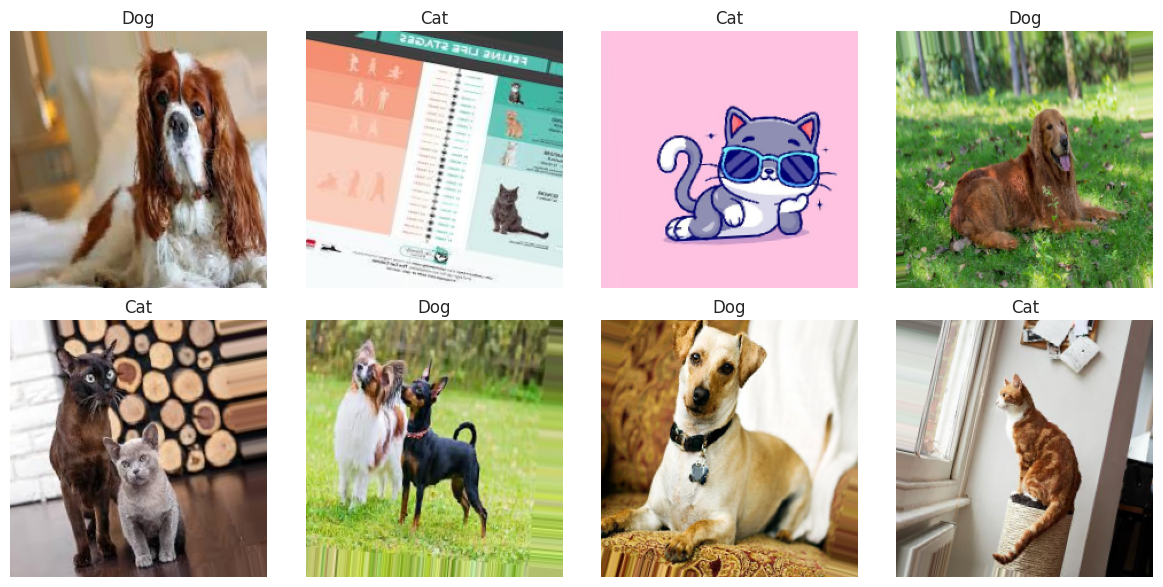

In [65]:
# Visualise a batch of images

images, labels = next(iter(train_images))
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.title('Dog' if labels[i] else 'Cat')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [66]:
# Build and Compile Model (Transfer Learning)

base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

inputs = Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [67]:
# Train the Model

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2)
    ]
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5379 - loss: 0.7763 - val_accuracy: 0.8125 - val_loss: 0.4448 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8667 - loss: 0.3744 - val_accuracy: 0.9196 - val_loss: 0.2636 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9265 - loss: 0.2524 - val_accuracy: 0.9286 - val_loss: 0.2050 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9464 - loss: 0.1761 - val_accuracy: 0.9375 - val_loss: 0.1833 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9494 - loss: 0.1485 - val_accuracy: 0.9464 - val_loss: 0.1612 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9480 - loss: 0.1395 - val_accuracy: 0.9375 - val_loss: 0.1547 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9575 - loss: 0.1453 - val_accuracy: 

In [69]:
# Fine-tune MobileNetV2

# Unfreeze the last 20 layers of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning!
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8402 - loss: 0.3072 - val_accuracy: 0.9554 - val_loss: 0.1128
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8986 - loss: 0.1995 - val_accuracy: 0.9554 - val_loss: 0.1184
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9188 - loss: 0.1938 - val_accuracy: 0.9554 - val_loss: 0.1246
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9435 - loss: 0.1562 - val_accuracy: 0.9554 - val_loss: 0.1311


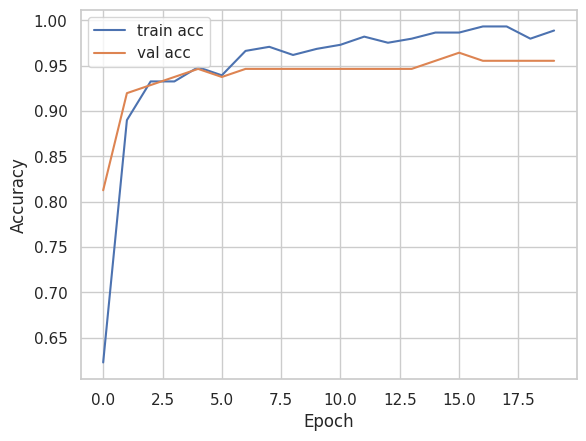

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9070 - loss: 0.1849
Test accuracy: 0.936


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
              precision    recall  f1-score   support

         Cat       1.00      0.87      0.93        70
         Dog       0.89      1.00      0.94        70

    accuracy                           0.94       140
   macro avg       0.94      0.94      0.94       140
weighted avg       0.94      0.94      0.94       140



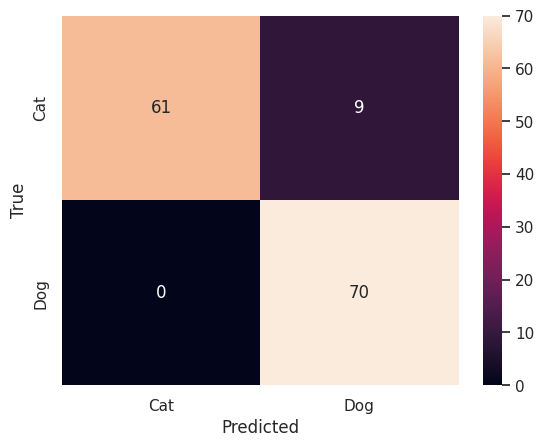

In [70]:
# Evaluate and Visualise Results

# Plot training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_images)
print(f"Test accuracy: {test_acc:.3f}")

# Classification report
test_images.reset()
y_true = test_df['Label'].map({'Cat':0, 'Dog':1}).values
y_pred = (model.predict(test_images) >= 0.5).astype(int).reshape(-1)
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [72]:
# Save the model

model.save("catdog_classifier_mobilenetv2.keras")